# Models: Generalized Matrix Factorization (GMF)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH             = '../..'
LIB_PATH              = f'{BASE_PATH}/lib'

In [3]:
import sys
sys.path.append(LIB_PATH)

import numpy as np
import pandas as pd
from bunch import Bunch

import torch
from torch.utils.data import DataLoader, Subset
from torch.optim import SparseAdam, Adam
from sklearn.metrics import roc_auc_score

import pytorch_common.util as pu
from pytorch_common.modules.fn import Fn
from pytorch_common.callbacks import EarlyStop, \
                                     ReduceLROnPlateau, \
                                     Validation, \
                                     SaveBestModel
from pytorch_common.callbacks.output import Logger, \
                                            MetricsPlotter

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import data as dt

import logging
import random

import util as ut

2023-08-22 19:47:34.841594: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Figure size 640x480 with 0 Axes>

## Setup

In [4]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [5]:
import pytorch_common
pytorch_common.__version__

'0.3.2'

In [6]:
torch.__version__

'2.0.1+cu118'

In [7]:
pu.set_device_name('gpu')
cpu = torch.device("cpu")

pu.get_device(), torch.cuda.is_available()

(device(type='cuda', index=0), True)

In [8]:
ut.set_seed(42)

## Classes

In [9]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).int().to(device)


class DatasetFactory:
    def __init__(
        self,
        feature_columns = ['user_seq', 'item_seq'],
        target_column   = 'rating'
    ): 
        self.__features_fn = lambda obs, device: to_tensor(obs, device, feature_columns)
        self.__target_fn   = lambda obs, device: to_tensor(obs, device, [target_column])   

    def create_from(self, df: pd.DataFrame):
        return ds.RecSysDataset(df, self.__features_fn, self.__target_fn)

class ModuleTrainer:
    def __init__(self, model): 
        self._model = model

    def __call__(self, train_ds, test_ds, params):
        model = self._model.to(params.model.device)
        ut.mkdir(params.model.weights_path)
        ut.mkdir(params.metrics.path)

        train_dl = DataLoader(
            train_ds, 
            params.train.batch_size, 
            num_workers = params.train.n_workers, 
            pin_memory  = True, 
            shuffle     = True
        )

        test_dl  = DataLoader(
            test_ds,
            params.train.batch_size,
            num_workers = params.train.n_workers,
            pin_memory  = True
        )

        result = model.fit(
            train_dl,
            epochs      = params.train.epochs,
            loss_fn     = ml.MSELossFn(),
            optimizer   = Adam(
                params = model.parameters(),
                lr     = params.train.lr
            ),
            callbacks   = [
                Validation(
                    test_dl,
                    metrics       = { 'val_loss': ml.MSELossFn(float_result=True) },
                    each_n_epochs = 1
                ),
                ReduceLROnPlateau(
                    metric   = 'val_loss', 
                    mode     = 'min', 
                    factor   = params.train.lr_factor, 
                    patience = params.train.lr_patience
                ),
                MetricsPlotter(
                    metrics            = ['train_loss', 'val_loss'], 
                    plot_each_n_epochs = 1,
                    output_path        = f'{params.metrics.path}/loss'
                ),
                Logger(['time', 'epoch', 'train_loss', 'val_loss', 'patience', 'lr']),
                SaveBestModel(
                    metric          = 'val_loss',
                    path            = ut.mkdir(params.model.weights_path),
                    experiment_name = params.metrics.experiment
                )
            ]
        )

        n_classes = len(train_ds.target_uniques)

        validator = ml.Validator(
            n_samples  = params.metrics.n_samples,
            batch_size = params.metrics.batch_size,
            metrics    = [
                mt.RMSE(),
                mt.MeanNdcgAtk            (k=5),
                mt.MeanAveragePrecisionAtk(k=5, discretizer=dr.between(4, 5)),
                mt.MeanUserFBetaScoreAtk  (k=5, n_classes=n_classes, discretizer=dr.between(4, 5)),
                mt.MeanUserPrecisionAtk   (k=5, n_classes=n_classes, discretizer=dr.between(4, 5)),
                mt.MeanUserRecallAtk      (k=5, n_classes=n_classes, discretizer=dr.between(4, 5))
            ],
            predictors = [ml.ModulePredictor(model)]
        )

        summary = validator.validate(test_ds)
        summary.save(f'{params.metrics.path}/metrics')

        results = summary.show()

        summary.plot(log_path_builder=ut.LogPathBuilder(params.metrics.path))
        
        return results

## Definicion del modelo

In [10]:
train_df = pd.read_json("/var/tmp/rec-sys-client/compute_knn_item_based_rating_matrix_train_interactions.json")
test_df  = pd.read_json("/var/tmp/rec-sys-client/compute_knn_item_based_rating_matrix_future_interactions.json")

train_ds = DatasetFactory().create_from(train_df)
test_ds  = DatasetFactory().create_from(test_df)

In [11]:
params = Bunch({    
    'model': Bunch({
        'n_users'       : len(train_ds.features_uniques[0]),
        'n_items'       : len(train_ds.features_uniques[1]),
        'device'        : pu.get_device(),
        'embedding_size': 50,
        'weights_path'  : f'{BASE_PATH}/weights'
    }),
    'train': Bunch({
        'lr'         : 0.001,
        'lr_factor'  : 0.05,
        'lr_patience': 3,
        'epochs'     : 12,
        'n_workers'  : 24,
        'batch_size' : 64
    }),
    'metrics': Bunch({
        'experiment' : 'gmf',
        'path'       : f'{BASE_PATH}/metrics/gmf',
        'n_samples'  : 1000,
        'batch_size' : 1000
    })
})

In [12]:
model = ml.GMF(
    n_users        = params.model.n_users,
    n_items        = params.model.n_items,
    embedding_size = params.model.embedding_size
)

trainer = ModuleTrainer(model)

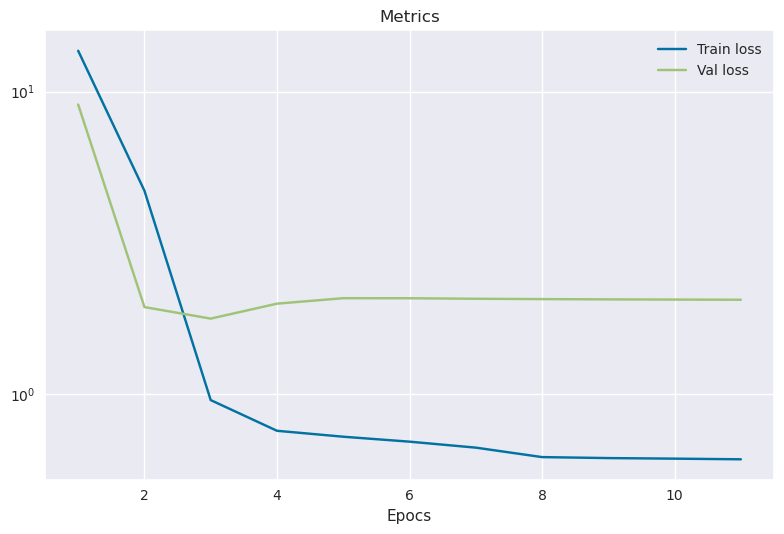

2023-08-22 19:49:11,799 - INFO - {'time': '0:00:07.80', 'epoch': 12, 'train_loss': 0.6040122793380157, 'val_loss': 2.048682451248169, 'lr': 2.5e-06}


Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

Ordered by mAP@5(4,5):


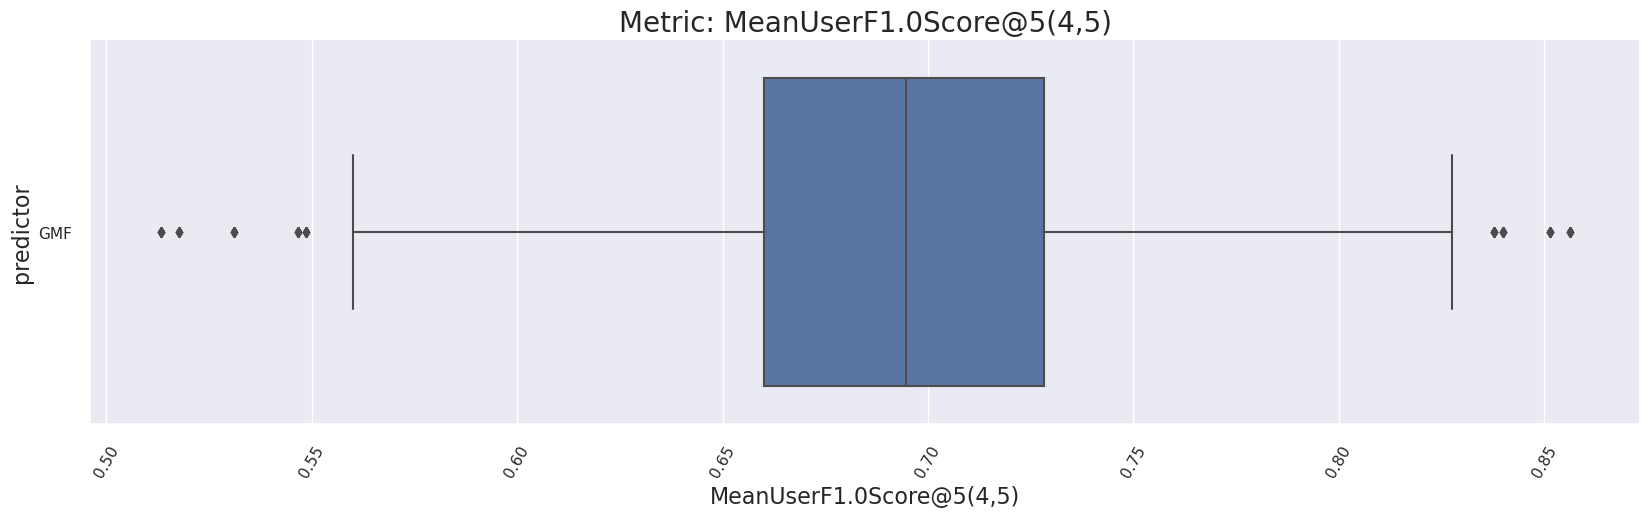

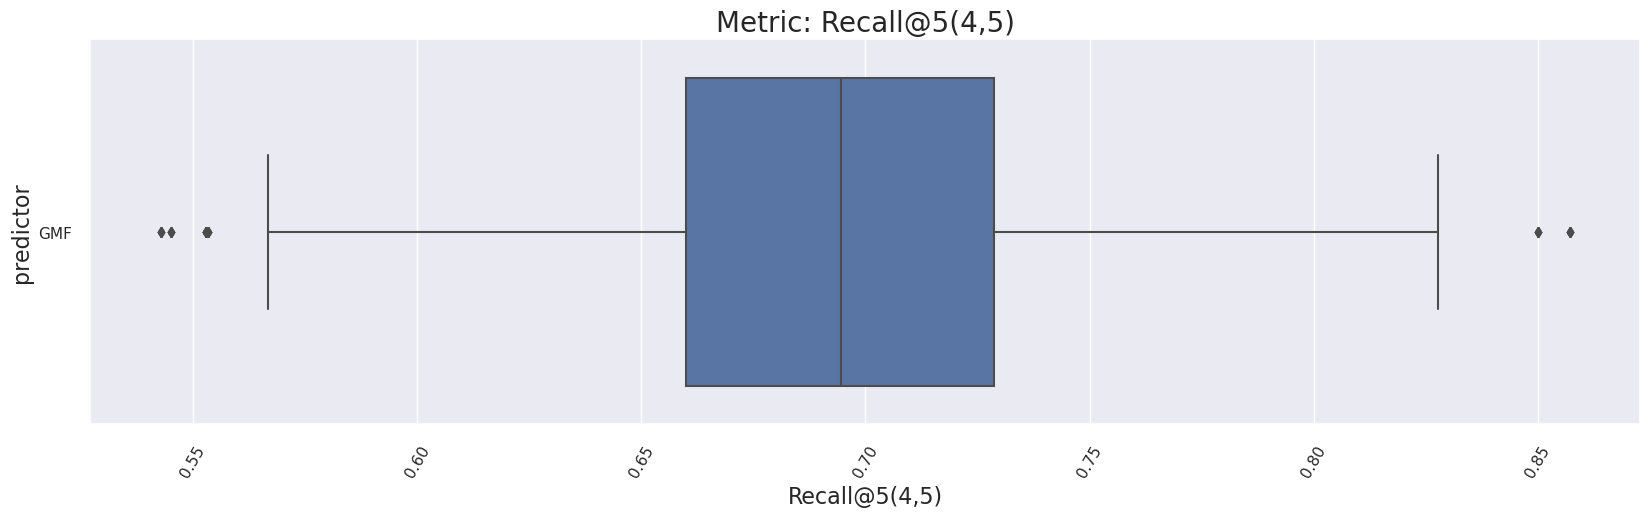

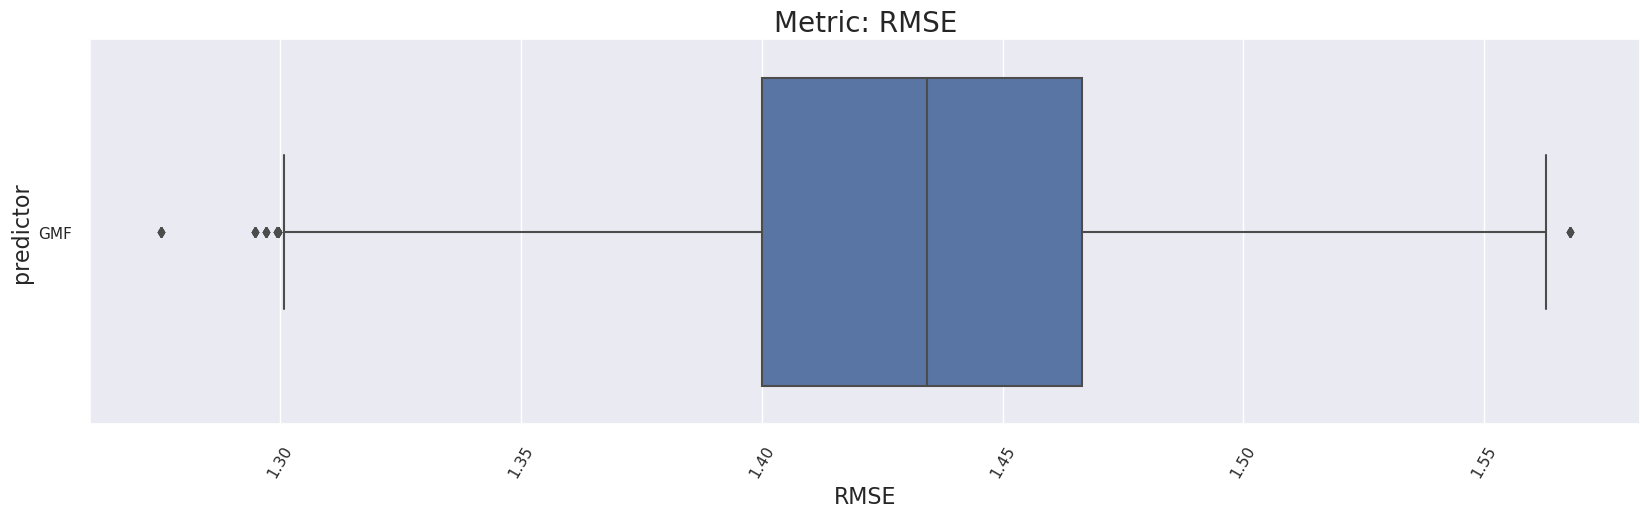

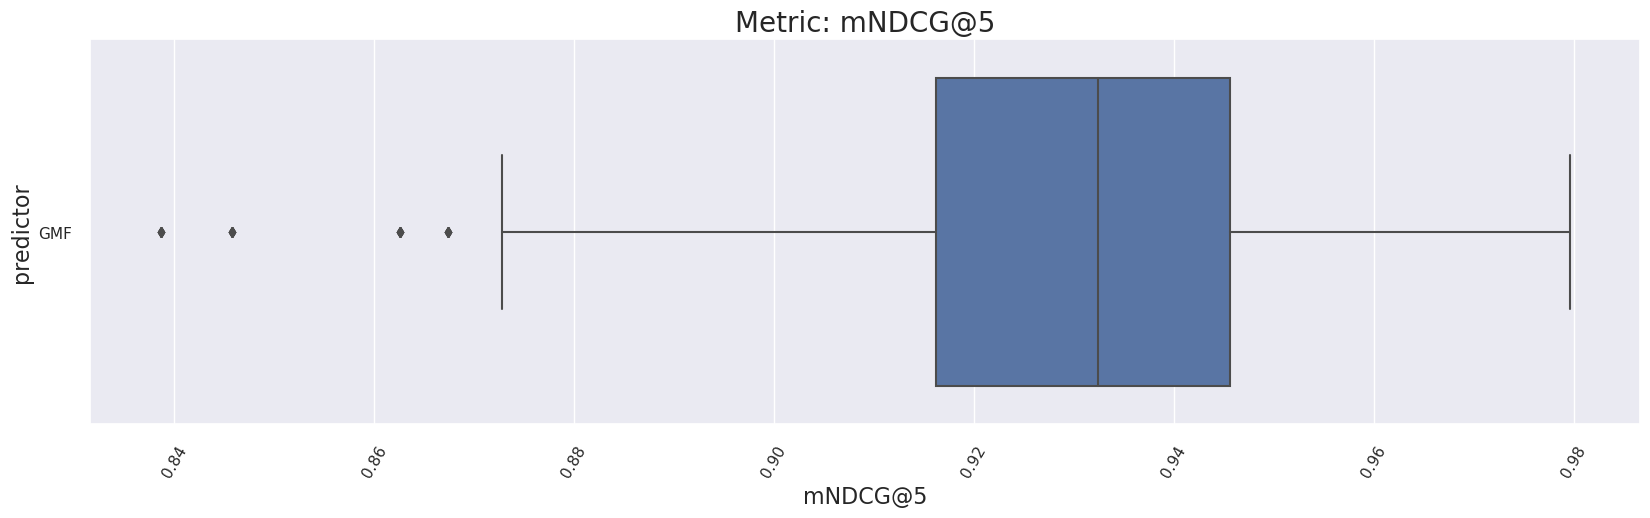

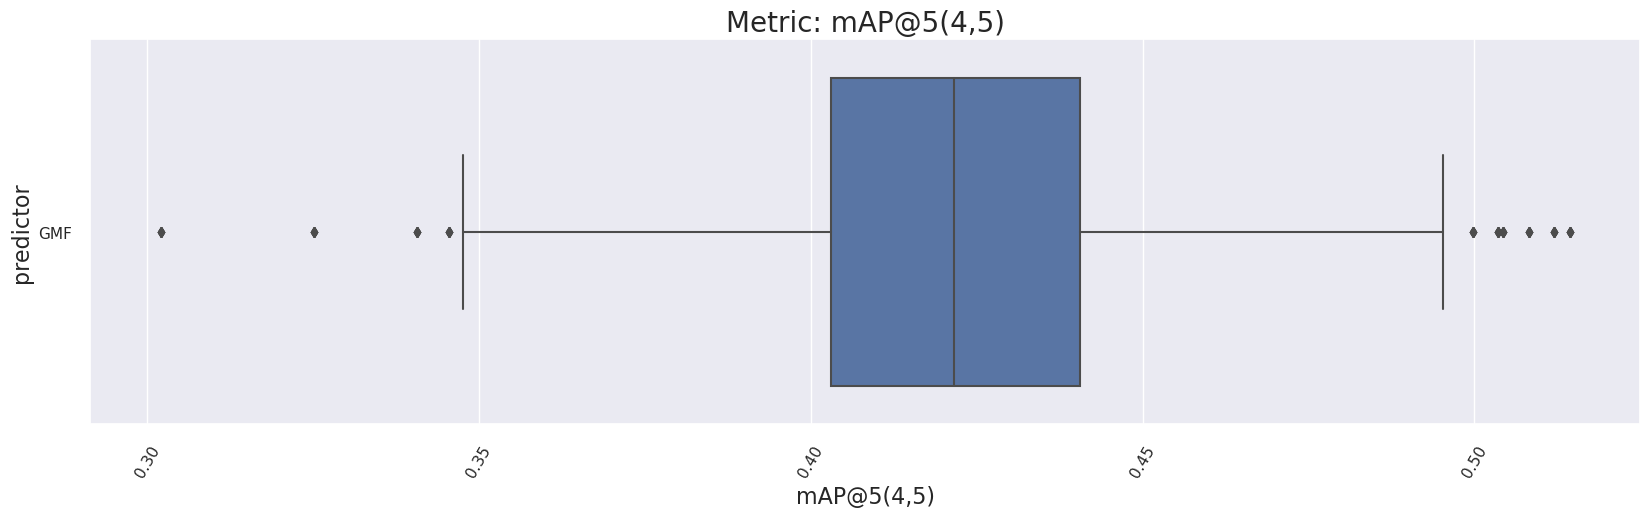

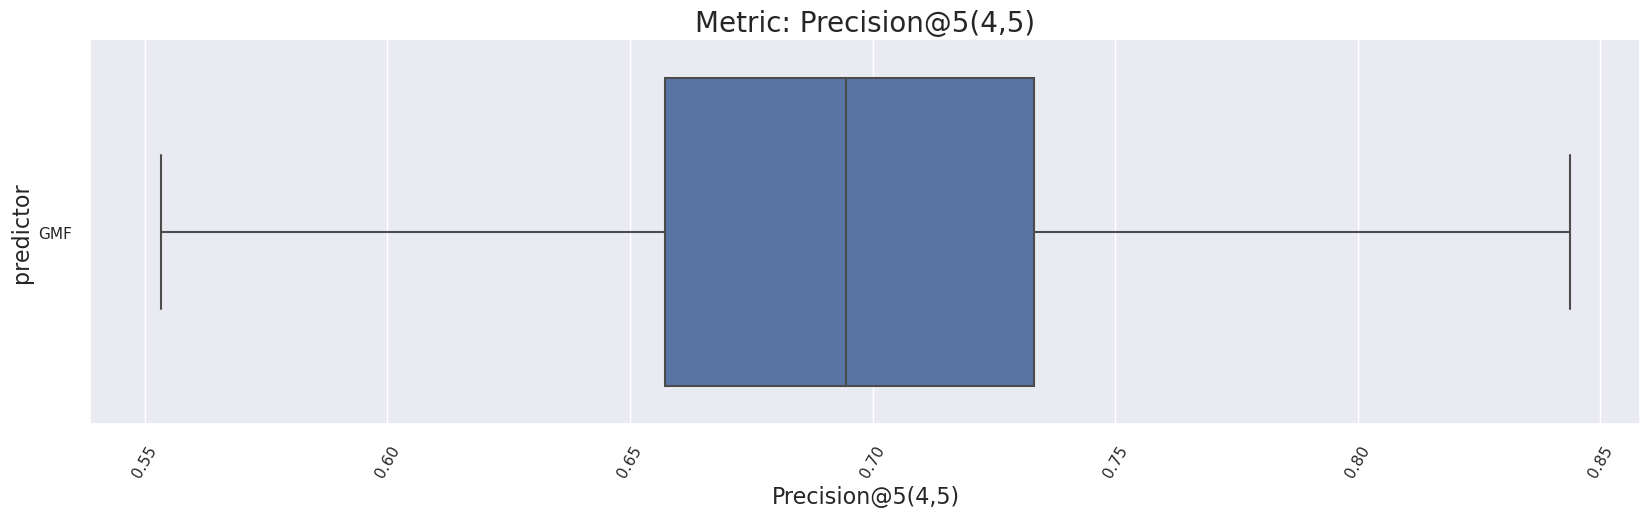

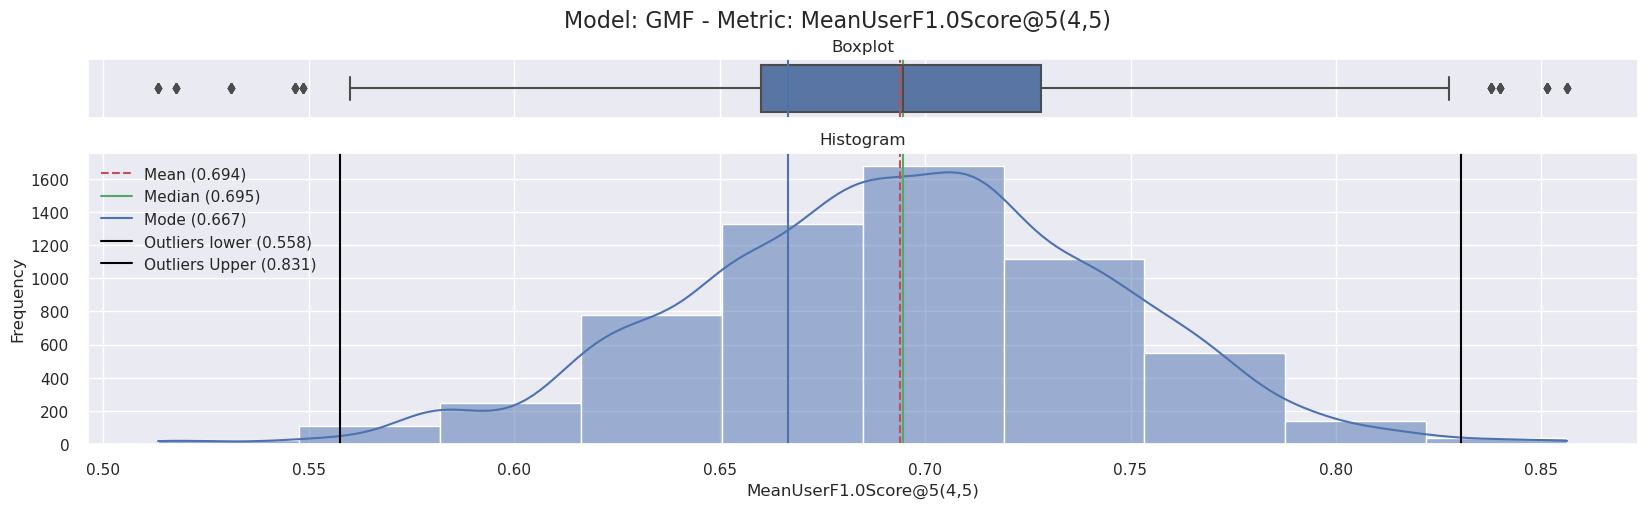

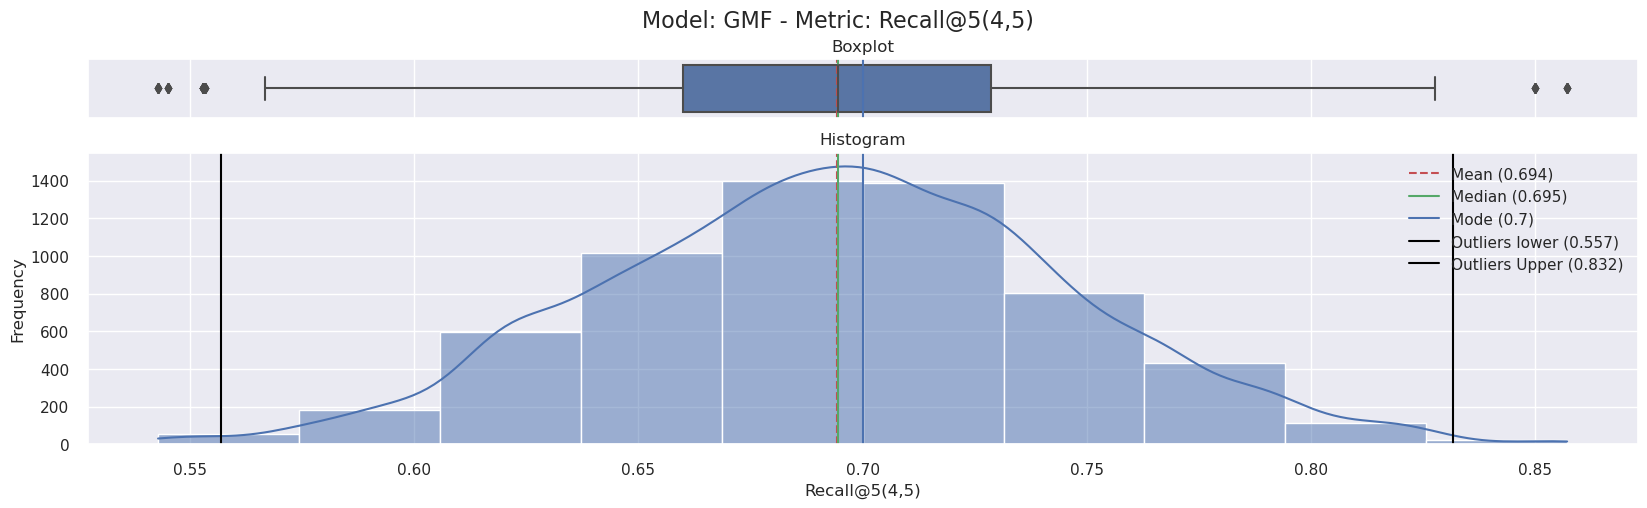

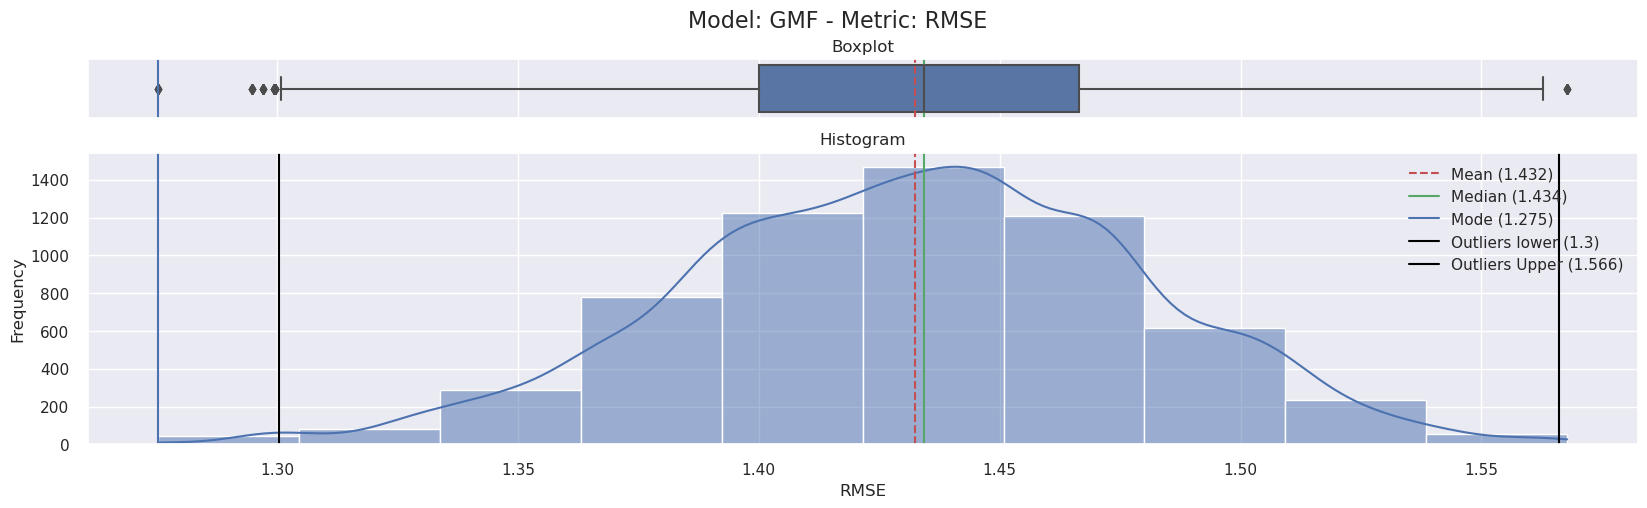

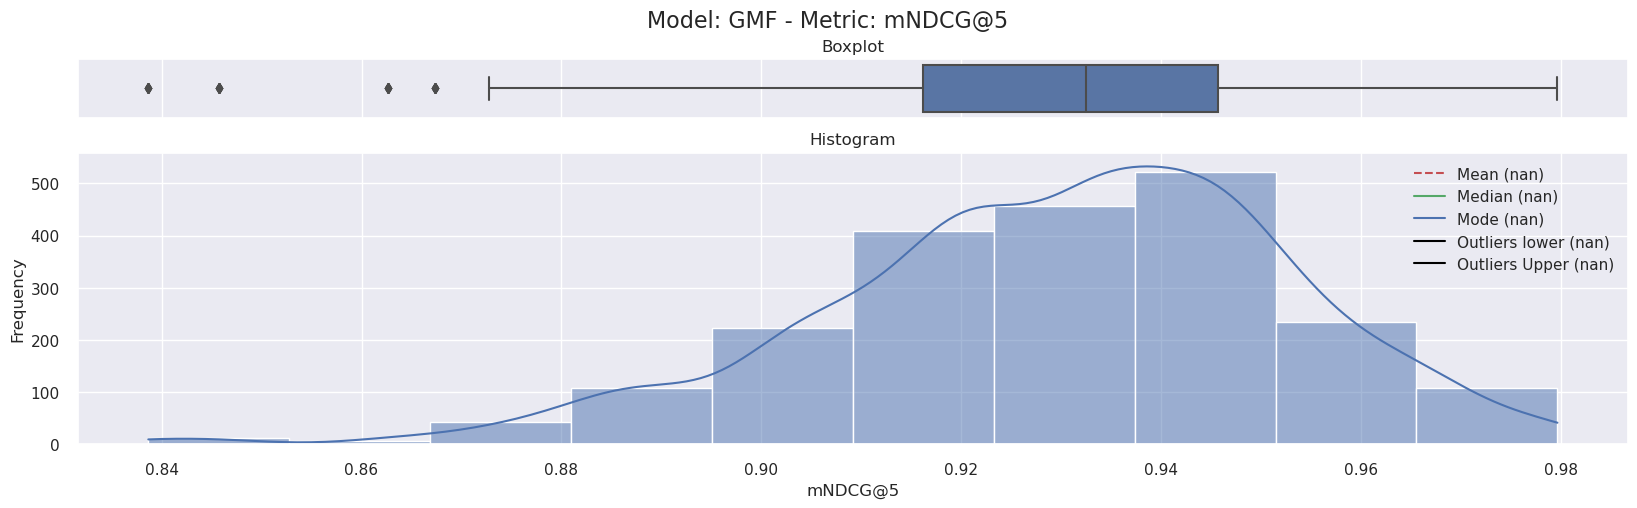

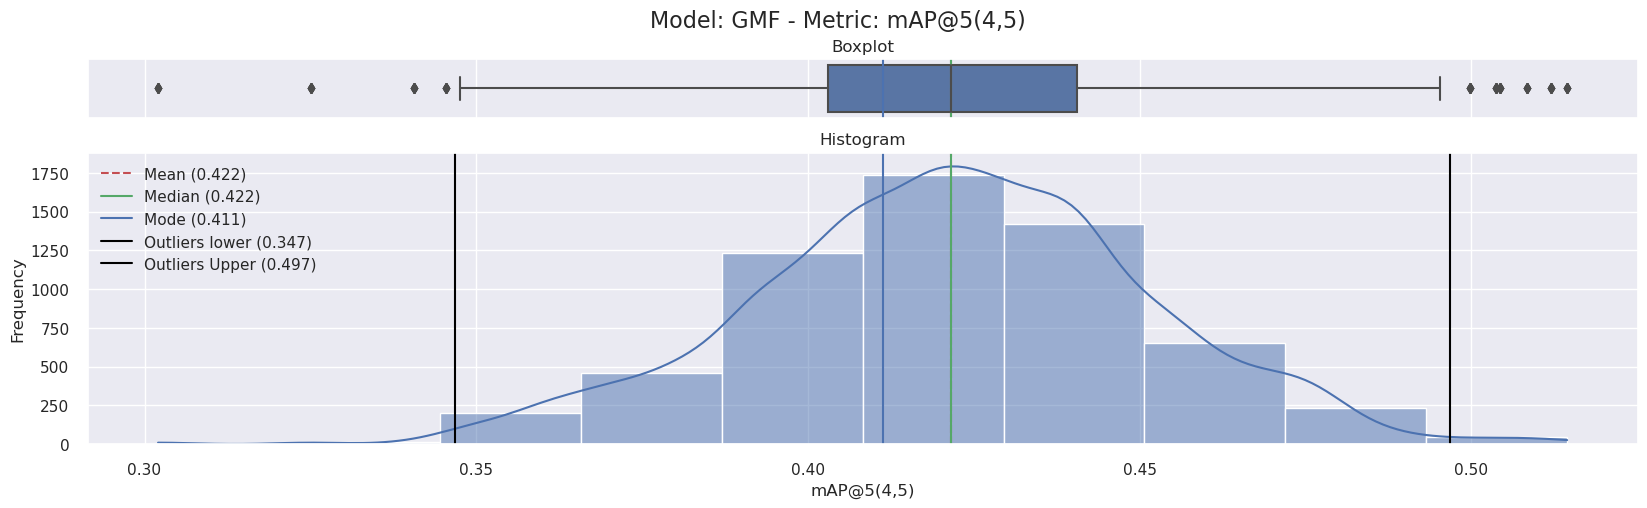

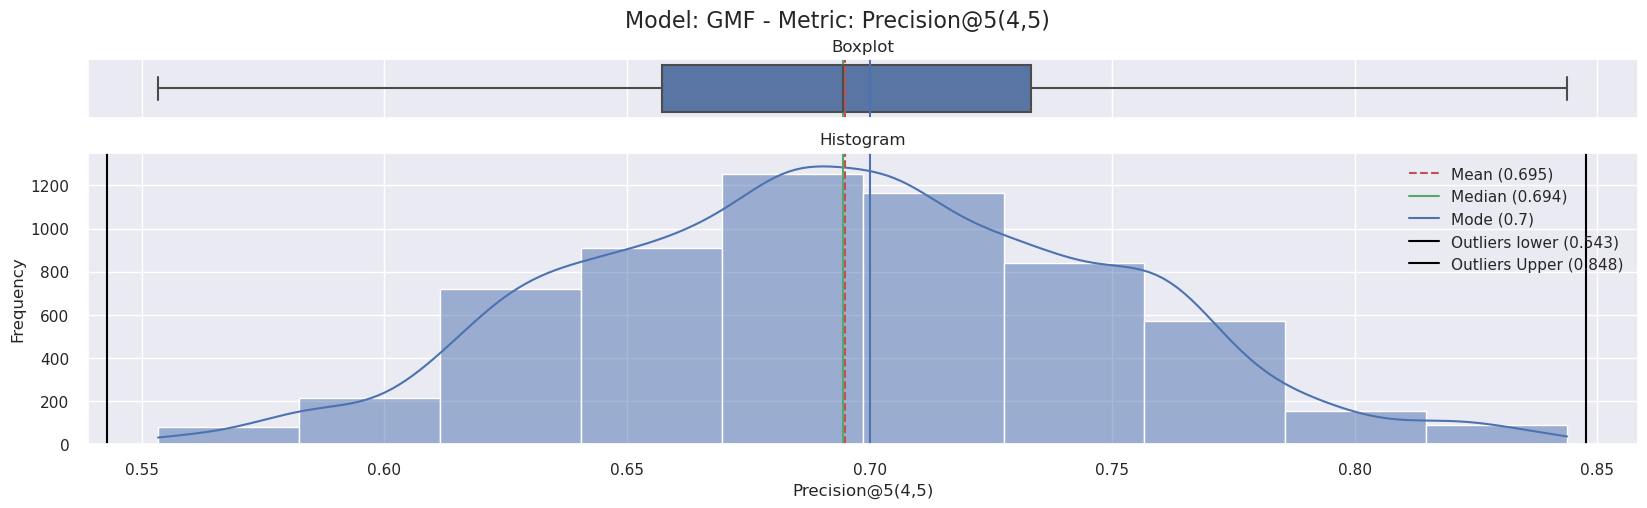

,sample,RMSE,mNDCG@5,"mAP@5(4,5)","MeanUserF1.0Score@5(4,5)","Precision@5(4,5)","Recall@5(4,5)"
predictor,,,,,,,
GMF,499.5,1.432442,0.92963,0.421549,0.693945,0.695014,0.694281


In [13]:
trainer(train_ds, test_ds, params)

In [14]:
resolver = pu.WeightsFileResolver(params.model.weights_path)

weights_file_path = resolver(experiment=params.metrics.experiment, metric='val_loss')

weights_file_path

'../../weights/2023-08-22_18-53-31--gmf--epoch_3--val_loss_1.725135326385498.pt'

In [15]:
model.load(weights_file_path)